In [1]:
import sympy
import os
import sympy.physics.mechanics as mech
import control
from IPython.display import Latex
%pylab inline
%load_ext autoreload

%autoreload 2
import my_util.px4_logutil
from my_util.px4_logutil import savitzky_golay
import scipy.integrate
import scipy.optimize
sympy.init_printing()
mech.init_vprinting()

from my_util.sympy_util import collect_within_terms, \
    labelled_sympy_eq, custom_latex_labelled_eq

Populating the interactive namespace from numpy and matplotlib


#Dynamics

##Kinematics

In [2]:
t, x, theta, alpha, m, J, g, l, w, v, m_w, r_w, J_w, V, T = \
    sympy.symbols('t, x, theta, alpha, m, J, g, l, w, v,'
                  'm_w, r_w, J_w, V, T')
A_x, f, k_emf, k_damp, J_m = sympy.symbols('A_x, f, k_emf, k_damp, J_m')
zeta_theta, wn_theta, theta_c, x_c = sympy.symbols(r'zeta_theta, \omega_{\theta}, \theta_c, x_c')
zeta_x, wn_x = sympy.symbols(r'zeta_x, \omega_{x}')
x_ddot_d, theta_ddot_d = sympy.symbols(r'\ddot{x}_d ,\ddot{\theta}_d')

In [3]:
frame_i = mech.ReferenceFrame('i')
frame_b = frame_i.orientnew('b', 'Axis', (theta(t), frame_i.y))
frame_w = frame_b.orientnew('b', 'Axis', (alpha(t), frame_b.y))

In [4]:
point_o = mech.Point('o')
point_o.set_vel(frame_i, 0)

In [5]:
point_a = point_o.locatenew('a', x(t)*frame_i.x)
point_a.set_vel(frame_b, 0)
point_a.set_vel(frame_i, point_a.pos_from(point_o).diff(t, frame_i))
point_a.set_acc(frame_i, point_a.vel(frame_i).diff(t, frame_i))

In [6]:
point_p = point_a.locatenew('p', -l*frame_b.z)
point_p.set_vel(frame_b, 0)
point_p.v1pt_theory(point_a, frame_i, frame_b)
point_p.a2pt_theory(point_a, frame_i, frame_b);

In [7]:
custom_latex_labelled_eq('^i\mathbf{a}^p', point_p.acc(frame_i))

##No Slip Constraint

We assume that the wheel does not slip, so that as the vehicle translates, the wheel rotate accordingly.

In [8]:
no_slip_wheel_1 = (point_a.vel(frame_i) - \
    r_w*frame_w.ang_vel_in(frame_i).dot(frame_i.y)*frame_i.x).dot(frame_i.x)
custom_latex_labelled_eq('0', no_slip_wheel_1)

The derivative of this constraint equation will also be useful.

In [9]:
no_slip_wheel_2 = no_slip_wheel_1.diff(t)
custom_latex_labelled_eq('0', no_slip_wheel_2)

When deriving the equation of motion, we can therefore use the following substitution.

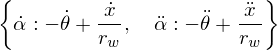

In [10]:
no_slip_sub = {
    alpha(t).diff(t): sympy.solve(no_slip_wheel_1, alpha(t).diff(t))[0],
    alpha(t).diff(t,2): sympy.solve(no_slip_wheel_2, alpha(t).diff(t,2))[0]
}
no_slip_sub

##Motor Dynamics

The motor dynamics are described by a second order system with a pole at the origin. This model is simplified but captures the damping of the motor, the torque created by the applied voltage, and the influence of the external torque on the motor.

In [11]:
M_motor = T + k_emf*V - k_damp*alpha(t).diff(t)
eom_motor_alpha = M_motor - J_m*alpha(t).diff(t,2)
sympy.Eq(eom_motor_alpha,0)
custom_latex_labelled_eq('0',eom_motor_alpha)

where $T$ is the external torque, $J_m$, is the motor inertia, $k_emf$ is the electromotive constant, and $k_damp$ is the motor damping constant.

If we substitute the no slip wheel condition, we can express this eom in terms of the system states $(\theta, \dot{\theta}, x, \dot{x})$ and their derivatives.

In [12]:
eom_motor = eom_motor_alpha.subs(no_slip_sub)
custom_latex_labelled_eq('0', eom_motor)

##Wheel Dynamics

The force on the wheel is located at the bottom of the wheel and given by:

In [13]:
F_wheel = (A_x - f + v)*frame_i.x
custom_latex_labelled_eq('\mathbf{F}^{wheel}',F_wheel)

where $A_x$ is the reaction force of the axle, $f$ is the friction force created by the ground to enforce the no slip constraint, and $v$ is an unknown disturbance force that could represent wheel slip or various other unmodelled forces.


The moment on the wheel about the axle ($a$) is given by:

In [14]:
M_a_wheel = (T - f*r_w)*frame_b.y
sympy.Eq(sympy.Symbol('M_a'), M_a_wheel.dot(frame_b.y))
custom_latex_labelled_eq('\mathbf{M}_a^{wheel}',M_a_wheel)

where $f$ is the friction force acting on the bottom of the wheel, $r_w$ is the radius of the wheel, and $T$ is the torque acting through the motor shaft.

The rigid body dynamics of the wheel are goverened by Newton's 2nd Law:

In [15]:
eom_wheel_1 = (F_wheel - m_w*point_a.acc(frame_i)).dot(frame_i.x).subs(no_slip_sub)
sympy.Eq(eom_wheel_1, 0)
custom_latex_labelled_eq('0',eom_wheel_1)

where $A_x$ is the reaction force of the axle, $f$ is the friction force created by the ground to enforce the no slip constraint, $m_w$ is the mass of the wheel, $\ddot{x}$ is the acceleration of the wheel axle, and $v$ is an unknown disturbance force that could represent wheel slip or various other unmodelled forces.

The rigid body rotational dynamics of the wheel are goverend by Euler's 2nd law:

In [16]:
eom_wheel_2 = (M_a_wheel - J_w*frame_w.ang_acc_in(frame_i)).dot(frame_b.y).subs(no_slip_sub).simplify()
custom_latex_labelled_eq('0',eom_wheel_2)

where $J_w$ is the rotational inertia of the wheel, $r_w$ is the radius of the wheel, $f$ is the friction force created by the ground to enforce the no slip constraint, and $T$ is the torque acting through the motor shaft.

##Pendulum Dynamics

In [17]:
F_pend = (-2*A_x)*frame_i.x # two wheels
M_a_pend = (m*g*l*sympy.sin(theta(t)) - 2*(T + w))*frame_b.y # two wheels

In [18]:
eom_pend_1 = (F_pend - m*point_p.acc(frame_i)).dot(frame_i.x)
custom_latex_labelled_eq('0',eom_pend_1)

In [19]:
eom_pend_2 = (M_a_pend - J*frame_b.ang_acc_in(frame_i)).dot(frame_b.y)
custom_latex_labelled_eq('0',eom_pend_2)

##Solve System of Equations

There are 5 equations of motion (2 from the pendulum, 2 from wheel, and 1 from the motor) and 5 unknowns ($f$, $A_x$, $T$, $\ddot{x}$, $\ddot{\theta}$).

In [20]:
sol = sympy.solve(
    [eom_pend_1, eom_pend_2, eom_wheel_1, eom_wheel_2, eom_motor],
    [f, A_x, T,  x(t).diff(t,2), theta(t).diff(t,2)])

In [21]:
simp_assump = {J_w:0, J_m:0, m_w:0}

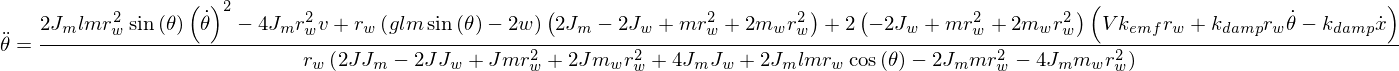

In [22]:
sympy.Eq(theta(t).diff(t,2), sol[theta(t).diff(t,2)])

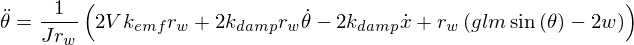

In [23]:
theta_ddot_eq = sol[theta(t).diff(t,2)].subs(simp_assump).simplify()
sympy.Eq(theta(t).diff(t,2), theta_ddot_eq)

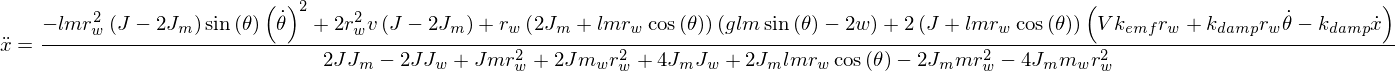

In [24]:
sympy.Eq(x(t).diff(t,2), sol[x(t).diff(t,2)])

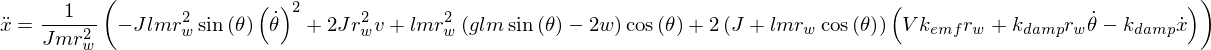

In [25]:
x_ddot_eq = sol[x(t).diff(t,2)].subs(simp_assump).simplify()
sympy.Eq(x(t).diff(t,2), x_ddot_eq)

#Dynamic Inversion Controller

##Dynamic Inversion for $\theta$

Now we extract the $\theta$ dynamics to prepare for dynamic inversion:

In [26]:
x_ddot_d, theta_ddot_d = sympy.symbols(r'\ddot{x}_d ,\ddot{\theta}_d')

In [27]:
theta_ddot_d_eq = -2*zeta_theta*wn_theta*theta(t).diff(t) - wn_theta**2*(theta(t)-theta_c(t))
sympy.Eq(theta_ddot_d, theta_ddot_d_eq)

Note that $\dot{\theta_c}$ can also be included if it is an analytical function, taking the numerical derivative of the reference is problemetic.

In [28]:
theta_ddot_V_inv= sympy.solve(theta_ddot_eq.subs(w,0) - theta_ddot_d, V)[0].expand().collect([theta_ddot_d, k_damp, J], sympy.factor)
#sympy.Eq(V, theta_ddot_V_inv)

In [29]:
theta_ddot_V_inv_d = theta_ddot_V_inv.subs(theta_ddot_d, theta_ddot_d_eq).expand().\
    collect([k_damp, J], sympy.factor)
#sympy.Eq(V, theta_ddot_V_inv_d)

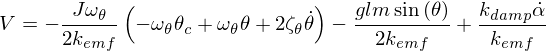

In [30]:
sympy.Eq(V, theta_ddot_V_inv_d.subs((sympy.solve(no_slip_wheel_1, alpha(t).diff(t))[0]*r_w).simplify(),
                                  alpha(t).diff(t)*r_w))

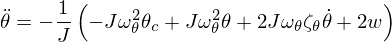

In [31]:
sympy.Eq(theta(t).diff(t,2), theta_ddot_eq.subs({V: theta_ddot_V_inv_d}).collect(w, sympy.factor))

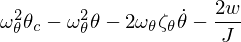

In [32]:
theta_dyn = theta_ddot_eq.subs({V: theta_ddot_V_inv_d}).collect(w, sympy.factor).ratsimp()
theta_dyn

In [33]:
theta_ddot_dist = (theta_dyn - theta_ddot_d_eq).simplify().expand().simplify().collect([J,J_m], sympy.factor)
custom_latex_labelled_eq(r'd_{\theta}', theta_ddot_dist)

The actual control input is duty cycle, so we must solve for the duty cycle required for the desired output Voltage.

In [34]:
V_batt, duty = sympy.symbols('V_batt, duty')
V_eq = V - V_batt*duty
sympy.Eq(V, sympy.solve(V_eq, V)[0])

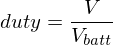

In [35]:
sympy.Eq(duty, sympy.solve(V_eq, duty)[0])

## Dynamic Inversion for x

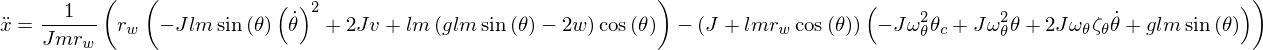

In [36]:
x_ddot_eq2 = x_ddot_eq.subs(V, theta_ddot_V_inv_d).simplify()
sympy.Eq(x(t).diff(t,2), x_ddot_eq2)

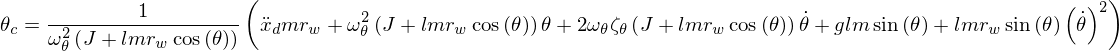

In [37]:
x_ddot_theta_inv = sympy.solve(x_ddot_eq2.subs({w:0, v:0}) - x_ddot_d, theta_c(t))[0].collect([theta(t), sympy.sin(theta(t))], sympy.factor)
sympy.Eq(theta_c(t), x_ddot_theta_inv)

In [38]:
x_dot_c, tau_x = sympy.symbols(r'\dot{x}_c, tau_x')
x_ddot_d_eq =  tau_x*(x(t).diff(t) - x_dot_c)
sympy.Eq(x_ddot_d, x_ddot_d_eq)

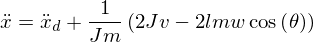

In [39]:
x_ddot_dyn = x_ddot_eq2.subs(theta_c(t), x_ddot_theta_inv)
x_ddot_dyn = x_ddot_d + (x_ddot_dyn - x_ddot_d).simplify().expand().\
    collect([w,v], sympy.factor).ratsimp().collect([w,v], sympy.factor)
sympy.Eq(x(t).diff(t,2), x_ddot_dyn)

In [40]:
x_ddot_dist = x_ddot_dyn - x_ddot_d
custom_latex_labelled_eq('d_x', x_ddot_dist)

How is disturbance term handled, want to make it appear as bounded input if possible.

# System Identification

## Motor

Several simple tests can be performed to find the motor coefficients using a simple dynamic inversion control law.

### Electromotive Force Coefficient ($k_{emf}$)

To find the electromotive force coefficient, we can use the known gravitational torque of the pendulum. The center of mass of the pendulum, $l$, can be found by balancing the pendulum without the wheels attached. The mass of the pendulum component of the segway (without the wheels), can also be found. The gravitational torque is then $T=mgl\sin(\theta)$.

Identification Procedure:
1. Measure the mass of the body of the segway without the wheels.
2. Use a balancing point to find the center of mass of the segway without the wheels.
3. Setup the controller to output $V=-mgl\cos(\theta)/c_{emf}$. Guess the initial value of $c_{emf}$ from the datasheet of the motor for the electromotive force constant or the max torque divided by the max voltage.
4. Angle the segway to several degrees (5 or more), and try to find the value of $c$ such that the segway is in dynamics equilibrium (where $\theta$ is approximately constant for a few seconds).
5. Repeat 3-4 until an acceptable value of $c_{emf}$ is found.

We know that the motor equation of motion is:

In [41]:
custom_latex_labelled_eq('0', eom_motor_alpha)

We substitute in $T=mgl\cos(\theta)$, $V=-mgl\cos(\theta)/k_{emf}$, $\dot{\alpha}=0$, $\ddot{\alpha}=0$ to arrive at the equation for $k_{emf}$.

In [42]:
k_emf_sysid_eq = sympy.solve(eom_motor_alpha.subs({alpha(t).diff(t):0, alpha(t).diff(t,2):0, \
                                  T:m*g*l*sympy.cos(theta(t)), V:-m*g*l*sympy.cos(theta(t))/sympy.Symbol('c_{emf}')}), k_emf)[0]
sympy.Eq(k_emf, k_emf_sysid_eq)

### Damping Coefficient ($k_{damp}$)

Identification Procedure:
1. Configure the feedback gains such that $V=c_{damp}\dot{\alpha}$. Choose a small value for $c$ initially so that the system remains stable. Take the system off the floor so that the external torque $T$  is zero.
2. Manually spin the wheel.
3. If the wheel doesn't continue spinning for several seconds, set $c_{damp}$ higher. If the wheel starts spinning faster, lower $c$. Then repeat starting at 2. If the wheel spins continually for several seconds without speeding up, then stop.
4. The value of the feedback gain $c_{damp}$ times $k_{emf}$, is now approximately equal to the damping coefficient ($k_{damp}$).

We know that the motor equation of motion is:

In [43]:
custom_latex_labelled_eq('0', eom_motor_alpha)

Since for the experiment $T=0$, $V=c\dot{\alpha}$, and $\ddot{\alpha}=0$, we see that the equation of motion results in the equation:

In [44]:
k_damp_sysid_eq = sympy.solve(eom_motor_alpha.subs(
    {alpha(t).diff(t,2):0, T:0, V:sympy.Symbol('c_damp')*alpha(t).diff(t)}), k_damp)[0]
sympy.Eq(k_damp, k_damp_sysid_eq)

where $c$ is the feedback gain found in the procedure.

### Motor Inertia ($J_m$)

The inertia of the motor can be determined by the time constant of the motor with respect to a step response.

Identification Procedure:
1. Set the segway on a platform so that the wheels can freely spin.
2. Send a step response in voltage, the magnitude should be characteristic of typical motor voltages expected (e.g. (6V) on a 12V motor). We expect the time constant to be the same for all voltage steps if it is linear, but nonlinearities will cause some variation dependent on the magnitude of the step.
3. Using log plots of motor voltage (QGroundControl Out1 packet), and the motor encoder packet, determine when the speed of the motor reaches 63.2% (1 - 1/e) of the maximum.

In [45]:
sympy.Eq(0,eom_motor_alpha)

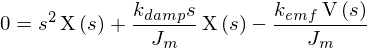

In [46]:
s, X = sympy.symbols('s, X')
fd_eom_motor = (eom_motor_alpha/(-J_m)).expand().subs(
    {alpha(t).diff(t,2): s**2*X(s), alpha(t).diff(t): s*X(s), alpha(t): X, T:0, V:V(s)})
sympy.Eq(0,fd_eom_motor)

The transfer function for the position of the motor is then:

In [47]:
G_m = sympy.solve(fd_eom_motor, X(s))[0]/V(s)
custom_latex_labelled_eq('G_{m}(s) = X(s)/ V(s)', G_m)

The transfer function of the velocity of the motor is then:

In [48]:
custom_latex_labelled_eq('G_{mv}(s) = sG_{m}(s)', s*G_m)

This is a standard first order plant:

$$G_{mv}(s) =\frac{K_{m}}{1+ s\tau_{m}}$$

$$K_{m} = \frac{k_{emf}}{k_{damp}}$$

$$\tau_{m} = \frac{J_m}{k_{damp}}$$

When the damping constant goes to zero, the equilibrium velocity of the motor is very high and it takes a long time to reach, thus increasing the time constant. When $J_m$ is very large, the response is sluggish so the time constant increases. Also note that this experiment can be coupled with the experiement for $k_{emf}$ to find $k_{damp}$ in place of the $k_{damp}$ experiement or to confirm the results.

# EKF Recursive System ID

In [49]:
x_vect = sympy.Matrix([theta(t), theta(t).diff(t), x(t), x(t).diff(t), m])
y_vect = sympy.Matrix([theta(t), theta(t).diff(t), x(t), x(t).diff(t)])
u_vect = sympy.Matrix([V])

In [50]:
f_vect = sympy.Matrix([theta(t).diff(t), theta_ddot_eq, x(t).diff(t), x_ddot_eq, 0])
f_vect = f_vect.subs({J_m:0, J_w:0, m_w:0, w:0, v:0}).\
    applyfunc(lambda e: e.expand().collect([sympy.sin(theta(t)), k_damp], sympy.factor))
custom_latex_labelled_eq('\dot{\mathbf{x}}(t)', f_vect)

In [51]:
F = f_vect.jacobian(x_vect).applyfunc(lambda e: e.expand().collect([k_damp, sympy.sin(theta(t))], sympy.factor))
#F

In [52]:
G = f_vect.jacobian(u_vect).applyfunc(lambda e: e.simplify())
#G

In [53]:
H = x_vect[0:4,:].jacobian(x_vect)
#H

In [54]:
x_def = sympy.DeferredVector('x')
x_sub = {theta(t):x_def[0], theta(t).diff(t): x_def[1], x(t): x_def[2], x(t).diff(t): x_def[3]}

In [55]:
def lambdify_state_space(expr, x_vect, u_vect, const, *args):
    x_sub = {}
    u_sub = {}
    x = sympy.DeferredVector('x')
    u = sympy.DeferredVector('u')
    for i in range(len(x_vect)):
        x_sub[x_vect[i]] = x[i]
    for i in range(len(u_vect)):
        u_sub[u_vect[i]] = u[i]
    expr = expr.subs(x_sub).subs(u_sub)
    f = sympy.lambdify((sympy.Symbol('t'), x, u)+args, expr.subs(x_sub).subs(u_sub).subs(const), default_array=True)
    return f

In [56]:
def linearize_state_space(f_vect, y_vect, x_vect, u_vect, segway_constants):
    f_A = lambdify_state_space(f_vect.jacobian(x_vect), x_vect, u_vect, segway_constants)
    f_B = lambdify_state_space(f_vect.jacobian(u_vect), x_vect, u_vect, segway_constants)
    f_C = lambdify_state_space(y_vect.jacobian(x_vect), x_vect, u_vect, segway_constants)
    f_D = lambdify_state_space(y_vect.jacobian(u_vect), x_vect, u_vect, segway_constants)
    f_f = lambdify_state_space(f_vect, x_vect, u_vect, segway_constants)
    f_g = lambdify_state_space(y_vect, x_vect, u_vect, segway_constants)
    return f_A, f_B, f_C, f_D, f_f, f_g 

In [57]:
with open('data/log_sysid_theta_closed/sess005/log001.csv') as f:
    log = my_util.px4_logutil.px4_log_to_namedtuple(f)

In [58]:
def get_data_from_log(log, i_start, i_end, cpr=3200):
    t = (log.TIME.StartTime[i_start:i_end] - log.TIME.StartTime[i_start])/1e6
    dt = savitzky_golay(t, 21, 1, 1)
    alpha0_dot = log.ENCD.vel0[i_start:i_end]*2*pi/cpr
    alpha1_dot = log.ENCD.vel1[i_start:i_end]*2*pi/cpr
    alpha0 = log.ENCD.cnt0[i_start:i_end]*2*pi/cpr
    alpha1 = log.ENCD.cnt1[i_start:i_end]*2*pi/cpr
    alpha = (alpha0 + alpha1)/2
    alpha_dot = (alpha0_dot + alpha1_dot)/2
    alpha_dot_smooth = savitzky_golay(alpha_dot, 21, 1)
    
    theta = log.ATT.Pitch[i_start:i_end]
    theta_cmd = log.ATSP.PitchSP[i_start:i_end]
    theta_dot = log.ATT.PitchRate[i_start:i_end]
    theta_dot_from_theta =  savitzky_golay(theta, 21, 1, 1)/dt
    
    x = log.LPOS.X[i_start:i_end]
    x_dot = log.LPOS.VX[i_start:i_end]
    
    alpha_dot_from_alpha = savitzky_golay(alpha, 21, 1, 1)/dt
    alpha_ddot_from_alpha_dot = savitzky_golay(alpha_dot, 51, 1, 1)/dt
    duty_pwm = (log.OUT1.Out0[i_start:i_end] + log.OUT1.Out1[i_start:i_end])/2
    duty = (duty_pwm - 1500)/1500
    V_batt = log.BATT.VFilt[i_start:i_end]
    V = detrend(V_batt*duty)
    return my_util.px4_logutil.dict_to_namedtuple('data', locals())

In [59]:
def do_ekf_fit(x0, data, P, Q, R, f_vect, y_vect, x_vect, u_vect, constants, show_percent=False):
    f_A, f_B, f_C, f_D, f_f, f_g = linearize_state_space(f_vect, y_vect, x_vect, u_vect, segway_constants)
    x_dot_smooth = savitzky_golay(data.x_dot, 11, 1)
    get_y = lambda i: [data.theta[i], data.theta_dot[i], data.x[i], x_dot_smooth[i]]
    x0[0:4] = get_y(0)
    sim = scipy.integrate.ode(f_f, f_A)
    sim.set_initial_value(x0, data.t[0])
    n_t = len(data.t)
    n_x = len(x0)
    n_u = 1
    x_hat = np.zeros((n_t, n_x))
    u_data = np.zeros((n_t, n_u))
    t_data = np.zeros(n_t)
    x_hat[0,:] = x0
    u_data[0,:] = data.V[0]
    t_data[0] = data.t[0]
    r_w_val = 0.1
    g_val = 9.8
    i_final = n_t
    for i in range(1,i_final):
        if show_percent and (i % 1000 == 0):
            print float(100*i)/i_final

        # current values
        t = data.t[i]
        dt = data.t[i] - data.t[i-1]
        y = get_y(i)
        u = [data.V[i]]

        # predict
        sim.set_f_params(u)
        sim.set_jac_params(u)
        sim.integrate(t)

        # linearize
        x = sim.y
        F = f_A(t, x, u)
        G = f_B(t, x, u)
        H = f_C(t, x, u)
        
        P = P + (F.dot(P) + P.dot(F.T) + Q)*dt
        S = H.dot(P).dot(H.T) + R
        K = P.dot(H.T).dot(inv(S))
        P = (np.eye(len(x)) - K.dot(H)).dot(P)

        r = y - f_g(t, x, u)[:,0]
        x = x +  K.dot(r)
        
        x_hat[i,:] = x
        sim.set_initial_value(x, t)
        u_data[i,:] = u
        t_data[i] = sim.t
    t_data = t_data[:i_final]
    x_hat = x_hat[:i_final,:]
    u_data = u_data[:i_final,:]
    return  my_util.px4_logutil.dict_to_namedtuple(
        'ekf_sim', {'t': t_data, 'x_hat': x_hat, 'u_data': u_data})

In [74]:
def comparison_plots(data, X):

    subplot(511)
    plot(data.t, X[:,2])
    plot(data.t, data.x, '.')
    #title('position')
    #xlabel('t, sec')
    ylabel('x, m')
    ylabel(r'$x$, m')
    legend(['estimated', 'measured'], loc='best')
    grid()

    subplot(512)
    plot(data.t, X[:,3])
    plot(data.t, data.x_dot, '.')
    #title('velocity')
    #xlabel('t, sec')
    ylabel(r'$\dot{x}$, m/s')
    #legend(['estimated', 'measured'], loc='best')
    grid()

    subplot(513)
    plot(data.t, rad2deg(X[:,0]))
    plot(data.t, rad2deg(data.theta), '.')
    #title('pitch')
    #xlabel('t, sec')
    ylabel(r'$\theta$, deg')
    #legend(['estimated', 'measured'], loc='best')
    grid()

    subplot(514)
    plot(data.t, rad2deg(X[:,1]))
    plot(data.t, rad2deg(data.theta_dot), '.')
    #title('pitch rate')
    #xlabel('t, sec')
    ylabel(r'$\dot{\theta}$, deg/s')
    #legend(['estimated', 'measured'], loc='best')
    grid()
    
    subplot(515)
    plot(ekf_sim.t, ekf_sim.x_hat[:,4:])
    hlines(segway_constants['m'], ekf_sim.t[0], ekf_sim.t[-1], linestyles='dashed')
    #title('mass convergence')
    ylabel('m, kg')
    xlabel('t, sec');
    legend(['estimated', 'known'], loc='best')
    grid()

In [75]:
data = get_data_from_log(log, 5000, 7000)

In [76]:
x0_std_dev = hstack((ones(4)*1e-1, ones(1)*5e-3))
w_std_dev = hstack(([1e-5, 1e-1, 1e-5, 1e-3], ones(1)*0))
v_std_dev = [1e-3, 1e-3, 1e-3, 1e-3]
P = diag(x0_std_dev)**2
Q = diag(w_std_dev)**2
R = diag(v_std_dev)**2
#P, Q, R

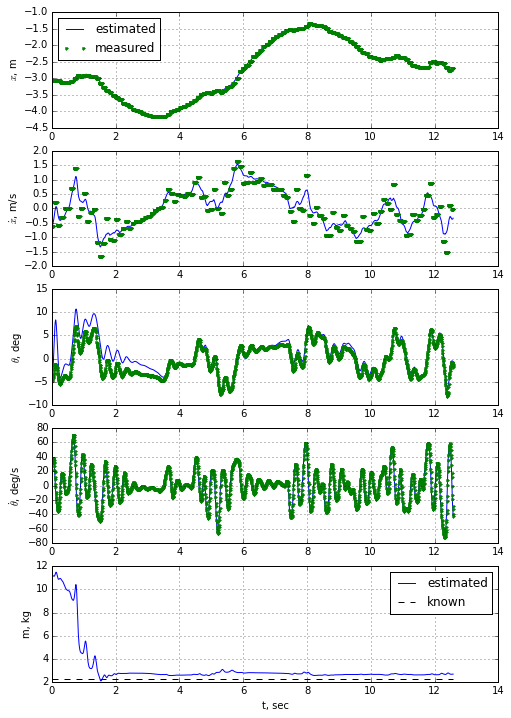

In [77]:
segway_constants = {'r_w':0.1,
                    'J': 0.45941763,
                    'l': 0.3175,
                    'k_damp': 0.050409123334297368,
                    'k_emf': 0.09172392,
                    'g': 9.8,
                    'm': 2.243
                    };
ekf_sim = do_ekf_fit([0,0,0,0,5*2.243], data, P, Q, R, f_vect, y_vect, x_vect, u_vect, segway_constants);
figure(figsize=(8,12))
comparison_plots(data, ekf_sim.x_hat)
savefig(os.path.join('figures', 'balance-online-m-identification.pdf'))

In [64]:
#check thata data is valid
#plt.plot(data.t, data.theta_dot, '.')
#plt.plot(data.t, data.theta_dot_from_theta)
#data.theta_dot_from_theta.dot(data.theta_dot_from_theta)/ (data.theta_dot.dot(data.theta_dot))

Note that a higher process error in the pitch rate was noted. This suggests that the torque model could be improved; however, the results are still accurate enough for the mass estimate to converge.

The rank of the linearized observability matrix is 5, which suggests that the mass parameter will be observable.

In [65]:
f_A, f_B, f_C, f_D, f_f, f_g = linearize_state_space(f_vect, y_vect, x_vect, u_vect, segway_constants)
x1 = [0.1,0.1,0.1,.1,2.2]
u1 = [0]
A = f_A(0, x1, u1)
C = f_C(0, x1, u1)
O = control.obsv(A, C)
rank = matrix_rank(control.obsv(A, C))
custom_latex_labelled_eq('rank(\mathcal{O})', rank)

In [66]:
O_sv = svd(O)[1]
O_sv_norm = O_sv/O_sv.max()
x_vect.T

In [67]:
O_sv_norm

array([  1.00000000e+00,   1.57784211e-01,   9.30122531e-02,
         7.67613698e-04,   5.40236029e-05])

In [68]:
m_f =  ekf_sim.x_hat[-1,4:][0]

Latex(r'$$m(t_{{final}})={:10.2f} \ \text{{kg}}$$'.format(m_f))

In [69]:
Latex(r'$$m_{{measured}}={:10.2f} \ \text{{kg}}$$'.format(segway_constants['m']))

##Identified Open Loop Linearized Dynamics

In [70]:
A = f_A(0, [0,0,0,0,m_f], [0])
B = f_B(0, [0,0,0,0,m_f], [0])
C = f_C(0, [0,0,0,0,m_f], [0])
D = f_D(0, [0,0,0,0,m_f], [0])
ss = control.ss(A,B,C,D);
#control.lqr(A[:4,:4], B[:4], eye(4), eye(1));

In [71]:
tfm = control.ss2tf(ss)
tfm


Input 1 to output 1:
       0.3993 s^2 + 4.441e-16 s
-------------------------------------
s^4 + 4.256 s^3 - 18.07 s^2 - 68.28 s

Input 1 to output 2:
0.3993 s^3 - 1.11e-15 s^2 - 1.954e-14 s
---------------------------------------
 s^4 + 4.256 s^3 - 18.07 s^2 - 68.28 s

Input 1 to output 3:
         0.8143 s^2 - 3.525e-15 s - 12.42
-------------------------------------------------
s^4 + 4.256 s^3 - 18.07 s^2 - 68.28 s + 2.345e-14

Input 1 to output 4:
 0.8143 s^3 - 3.83e-15 s^2 - 12.42 s
-------------------------------------
s^4 + 4.256 s^3 - 18.07 s^2 - 68.28 s

/home/jgoppert/.virtualenvs/dev/local/lib/python2.7/site-packages/control/matlab.py:1136: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if klist == None:


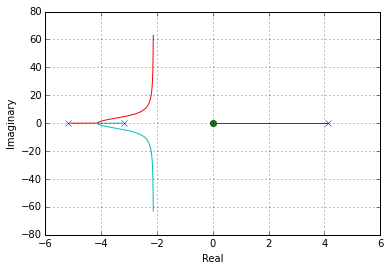

In [72]:
control.rlocus(control.ss2tf(ss[0,0]), logspace(0,4, 1000));
grid()

Figure(\ref{sb-open-loop-theta}) shows the open loop root locus from the Voltage to $\theta$, linearized about the vertical equilibrium position.

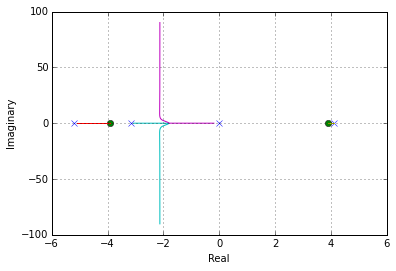

In [73]:
control.rlocus(control.ss2tf(ss[2,0]), logspace(0,4, 1000));
grid()

Figure(\ref{sb-open-loop-x}) shows the open loop root locus from the position, $x$, to the pitch angle, $\theta$, linearized about the vertical equilibrium position.